<a href="https://colab.research.google.com/github/k2herat/ML_hse_homeworks/blob/main/hw_2_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Машинное обучение

# Домашнее задание 2. Обучение без учителя, кластеризация.

## Общая информация
Дата выдачи: 02.10.2025

Дедлайн: 16.10.2025 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning.

In [1]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

## Часть 1. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [2]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
1289       politics  394.txt  Economy focus for election battle   
1872           tech  049.txt            Domain system scam fear   
1044       politics  149.txt   Blair returns from peace mission   
654   entertainment  145.txt   Sir Paul rocks Super Bowl crowds   
134        business  135.txt   Feta cheese battle reaches court   

                                                content  
1289   Britain's economic future will be at the hear...  
1872   A system to make it easier to create website ...  
1044   Prime Minister Tony Blair has arrived back fr...  
654    Sir Paul McCartney wowed fans with a live min...  
134    A row over whether only Greece should be allo...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [24]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [26]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

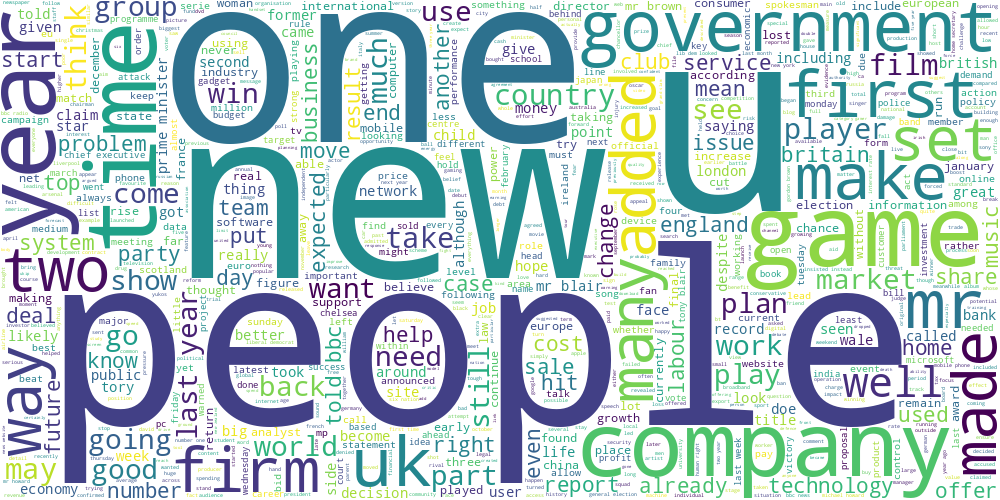

In [27]:
draw_wordcloud(data.text)

**Задание 1.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:** да, темы достаточно интерпретируемы:

0. всё, что связано с фильмами(премии, нагрды, сами фильмы, звезды)
1. английский футбол
2. экономика
3. технологии/it
4. государство
5. политика
6. бизнес
7. мировой спорт

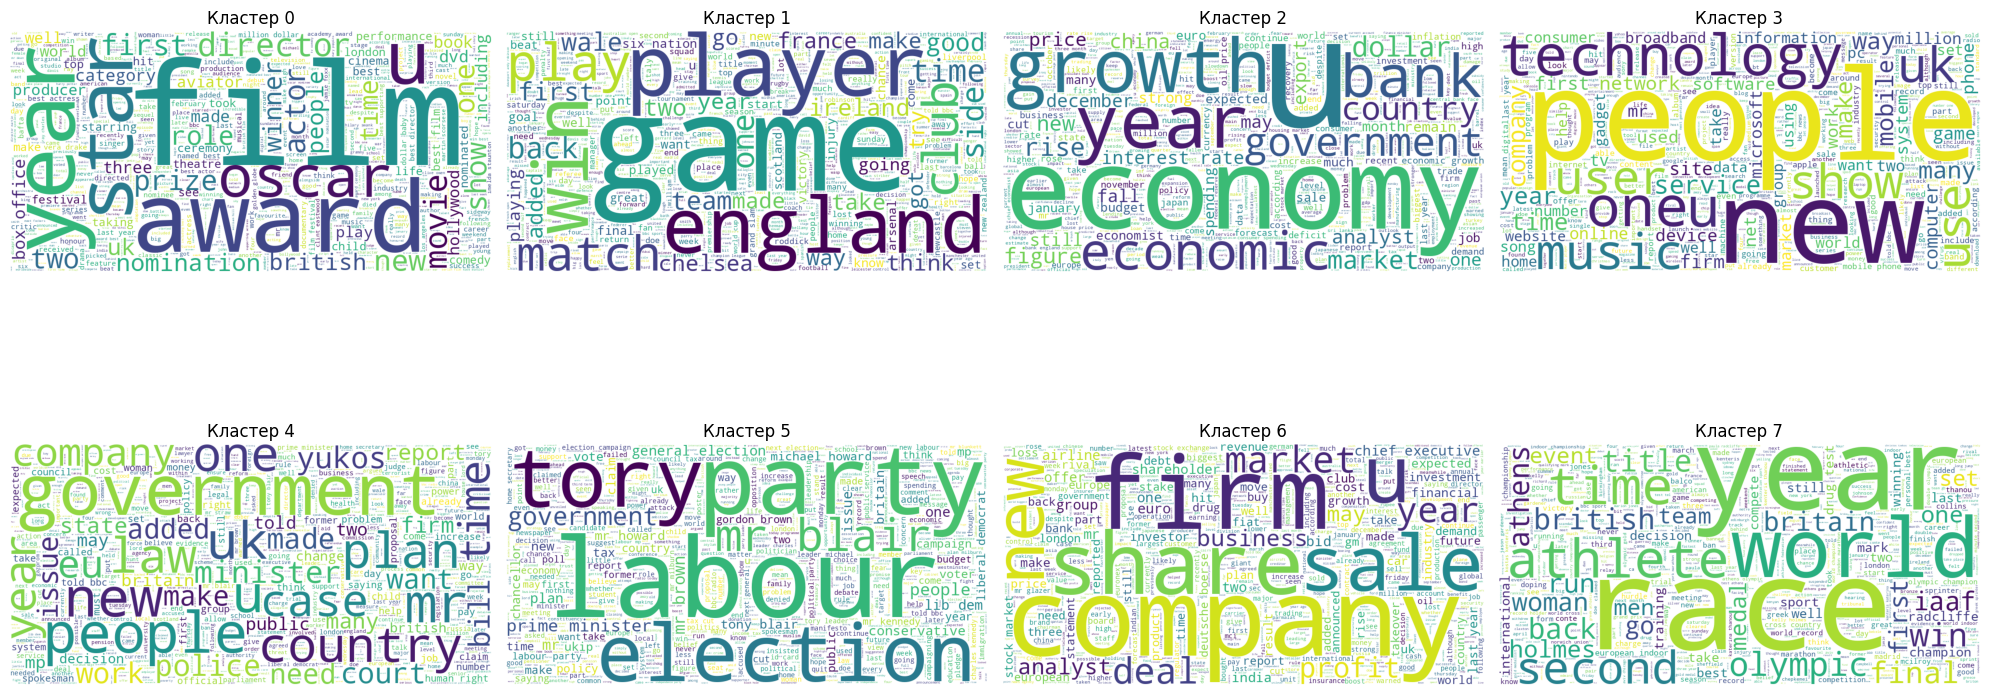

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    stop_words='english'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(data['text'])

kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)
data['cluster'] = clusters


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for cluster_num in range(8):
    cluster_texts = data[data['cluster'] == cluster_num]['text']
    wordcloud = draw_wordcloud(cluster_texts)
    axes[cluster_num].imshow(wordcloud)
    axes[cluster_num].set_title(f'Кластер {cluster_num}')
    axes[cluster_num].axis('off')

plt.tight_layout()
plt.show()

**Задание 1.2 (1 балл).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:** кажется, что примерно совпадают


In [28]:
centers = kmeans.cluster_centers_


feature_names = tfidf_vectorizer.get_feature_names_out()

n_top_words = 7

for cluster_num in range(8):
    center_vals = centers[cluster_num]
    top_indices = center_vals.argsort()[-n_top_words:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Кластер {cluster_num}: {', '.join(top_words)}")

Кластер 0: film, award, best, actor, oscar, star, director
Кластер 1: game, player, england, match, win, club, cup
Кластер 2: economy, bank, growth, rate, economic, price, dollar
Кластер 3: music, people, mobile, technology, phone, user, service
Кластер 4: mr, government, law, lord, minister, eu, court
Кластер 5: mr, labour, election, party, blair, tory, brown
Кластер 6: share, company, firm, profit, sale, market, deal
Кластер 7: olympic, race, athens, indoor, world, athlete, champion


**Задание 1.3 (2 балла).** Посмотрим на кластеризацию для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

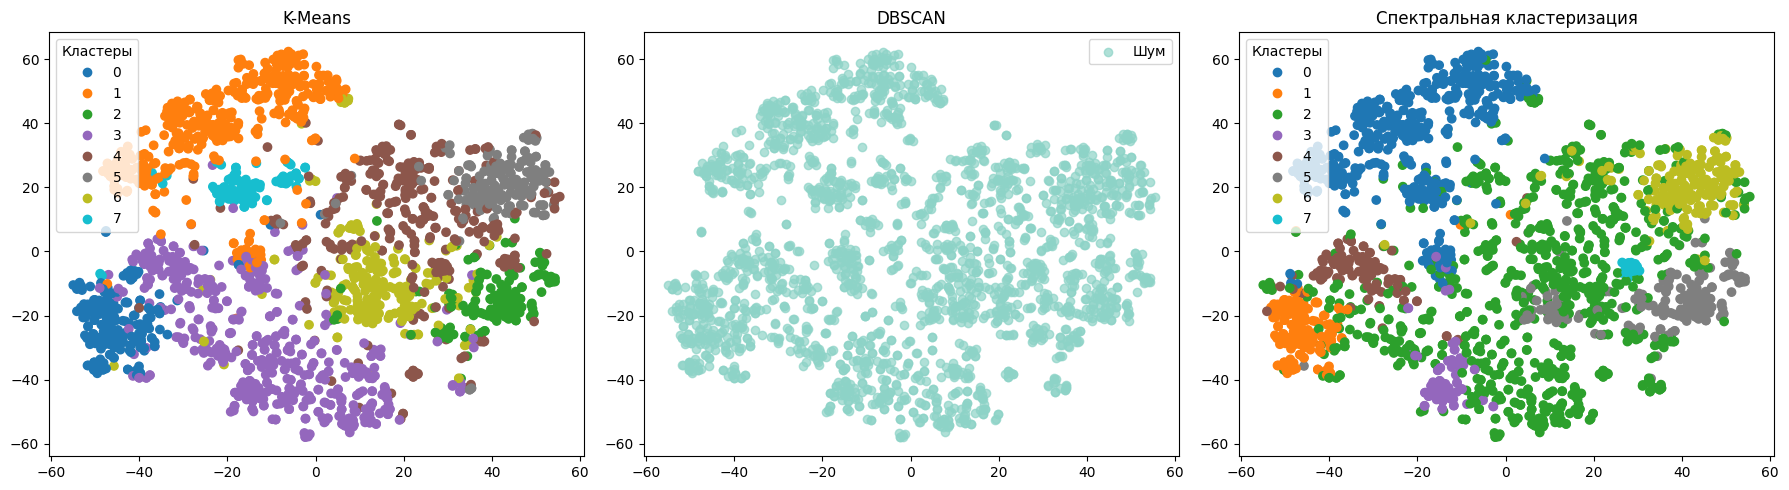

In [32]:
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(tfidf_matrix)

spectral = SpectralClustering(n_clusters=8, random_state=42)
spectral_clusters = spectral.fit_predict(tfidf_matrix.toarray())


tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tfidf_tsne = tsne.fit_transform(tfidf_matrix.toarray())


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


scatter1 = axes[0].scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=clusters, cmap='tab10')
axes[0].set_title('K-Means')
axes[0].legend(*scatter1.legend_elements(), title="Кластеры")


unique_dbscan = np.unique(dbscan_clusters)
colors_dbscan = plt.cm.Set3(np.linspace(0, 1, len(unique_dbscan)))
for i, cluster_id in enumerate(unique_dbscan):
    mask = dbscan_clusters == cluster_id
    label = 'Шум' if cluster_id == -1 else f'Кластер {cluster_id}'
    axes[1].scatter(tfidf_tsne[mask, 0], tfidf_tsne[mask, 1],
                   c=[colors_dbscan[i]], label=label, alpha=0.7)
axes[1].set_title('DBSCAN')
axes[1].legend()


scatter3 = axes[2].scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=spectral_clusters, cmap='tab10')
axes[2].set_title('Спектральная кластеризация')
axes[2].legend(*scatter3.legend_elements(), title="Кластеры")

plt.tight_layout()
plt.show()


Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:** у dbs все точки получились шумовые, балансы кластреров получились похожими судя по графику(knn и спектральная кластеризация), многие точки совпадают

**Задание 1.4 (2 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:**

Тема 0: club, united, woman, european, race, champion, time, world, season, manchester
Тема 1: people, user, net, software, site, computer, internet, use, network, information
Тема 2: best, award, music, year, band, song, album, prize, british, star
Тема 3: mobile, phone, people, camera, service, handset, operator, network, technology, use
Тема 4: year, growth, economy, price, rate, market, economic, month, rise, figure
Тема 5: china, bank, yukos, india, oil, company, firm, russian, government, country
Тема 6: mr, company, deal, bid, offer, executive, firm, share, chief, financial
Тема 7: england, wale, ireland, player, game, rugby, coach, nation, scotland, team
Тема 8: government, tax, people, mr, plan, year, country, brown, budget, council
Тема 9: film, star, movie, tv, child, actor, director, year, new, festival
Тема 10: sale, number, chart, year, christmas, week, office, day, uk, release
Тема 11: minute, chelsea, game, goal, arsenal, liverpool, ball, player, penalty, good
Тема 12: 

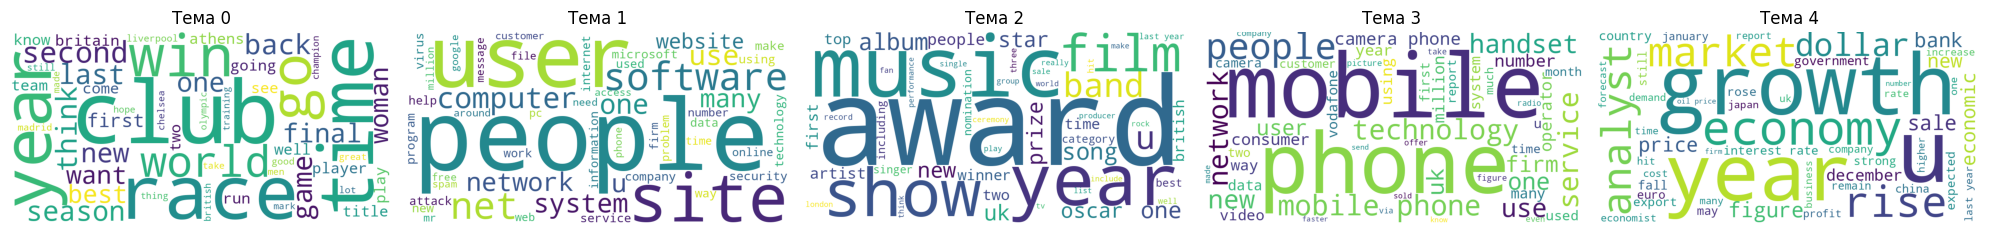

In [33]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.8,
    stop_words='english'
)

count_matrix = count_vectorizer.fit_transform(data['text'])


lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda_topics = lda.fit_transform(count_matrix)


lda_clusters = lda_topics.argmax(axis=1)
data['lda_cluster'] = lda_clusters


count_feature_names = count_vectorizer.get_feature_names_out()


def show_topic_words(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]
        print(f"Тема {topic_idx}: {', '.join(top_words)}")


show_topic_words(lda, count_feature_names)

interesting_topics = [0, 1, 2, 3, 4]

fig, axes = plt.subplots(1, len(interesting_topics), figsize=(20, 4))
if len(interesting_topics) == 1:
    axes = [axes]

for i, topic_num in enumerate(interesting_topics):
    topic_texts = data[data['lda_cluster'] == topic_num]['text']
    if len(topic_texts) > 0:
        wordcloud = draw_wordcloud(topic_texts, max_words=50)
        axes[i].imshow(wordcloud)
        axes[i].set_title(f'Тема {topic_num}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## Часть 2. Transfer learning для задачи классификации текстов

**Задание 2.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(
    data['text'], data['category'], test_size=0.2, random_state=42, stratify=data['category']
)


tfidf_vectorizer_full = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer_full.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer_full.transform(X_test)

lr_tfidf = LogisticRegression(random_state=42, max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)


kmeans_features = KMeans(n_clusters=20, random_state=42)
kmeans_features.fit(X_train_tfidf)


X_train_distances = kmeans_features.transform(X_train_tfidf)
X_test_distances = kmeans_features.transform(X_test_tfidf)

lr_kmeans = LogisticRegression(random_state=42, max_iter=1000)
lr_kmeans.fit(X_train_distances, y_train)
y_pred_kmeans = lr_kmeans.predict(X_test_distances)
acc_kmeans = accuracy_score(y_test, y_pred_kmeans)

count_vectorizer_full = CountVectorizer(max_features=1000)
X_train_count = count_vectorizer_full.fit_transform(X_train)
X_test_count = count_vectorizer_full.transform(X_test)

lda_features = LatentDirichletAllocation(n_components=20, random_state=42)
X_train_lda = lda_features.fit_transform(X_train_count)
X_test_lda = lda_features.transform(X_test_count)

lr_lda = LogisticRegression(random_state=42, max_iter=1000)
lr_lda.fit(X_train_lda, y_train)
y_pred_lda = lr_lda.predict(X_test_lda)
acc_lda = accuracy_score(y_test, y_pred_lda)

print(f"Accuracy Logistic Regression: {acc_tfidf:.4f}")
print(f"Accuracy K-Means + Logistic Regression: {acc_kmeans:.4f}")
print(f"Accuracy LDA + Logistic Regression: {acc_lda:.4f}")

Accuracy Logistic Regression: 0.9775
Accuracy K-Means + Logistic Regression: 0.9461
Accuracy LDA + Logistic Regression: 0.9483


У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** Лучше всего получилось у логистической регрессии, так как она не сжимает данные.

**Задание 2.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации.

In [44]:

X = data['text']
y = data['category']


from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

val_ratio = 0.30 / 0.95  # ≈ 0.3158

X_unlabeled, X_val, y_unlabeled, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_ratio,
    random_state=42,
    stratify=y_temp
)


X_unsupervised = pd.concat([X_labeled, X_unlabeled])


tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.8)
X_unsupervised_tfidf = tfidf_vectorizer.fit_transform(X_unsupervised)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

best_kmeans_score = 0
best_kmeans_n = 0
best_kmeans_model = None

for n_clusters in [50, 100, 150, 200, 250]:
    print(f"\nПробуем KMeans с n_clusters = {n_clusters}")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_unsupervised_tfidf)


    X_labeled_kmeans = kmeans.transform(tfidf_vectorizer.transform(X_labeled))
    X_val_kmeans = kmeans.transform(X_val_tfidf)

    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_labeled_kmeans, y_labeled)

    val_score = clf.score(X_val_kmeans, y_val)
    print(f"Accuracy на валидации: {val_score:.4f}")

    if val_score > best_kmeans_score:
        best_kmeans_score = val_score
        best_kmeans_n = n_clusters
        best_kmeans_model = kmeans

print(f"\nЛучший KMeans: n_clusters={best_kmeans_n}, val_accuracy={best_kmeans_score:.4f}")



count_vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.8)
X_unsupervised_count = count_vectorizer.fit_transform(X_unsupervised)
X_val_count = count_vectorizer.transform(X_val)
X_test_count = count_vectorizer.transform(X_test)

best_lda_score = 0
best_lda_n = 0
best_lda_model = None

for n_topics in [20, 50, 100, 150, 200]:
    print(f"\nПробуем LDA с n_topics = {n_topics}")

    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method='online',
        max_iter=10
    )
    lda.fit(X_unsupervised_count)

    X_labeled_lda = lda.transform(count_vectorizer.transform(X_labeled))
    X_val_lda = lda.transform(X_val_count)

    clf = LogisticRegression(random_state=42, max_iter=1000)
    clf.fit(X_labeled_lda, y_labeled)

    val_score = clf.score(X_val_lda, y_val)
    print(f"Accuracy на валидации: {val_score:.4f}")

    if val_score > best_lda_score:
        best_lda_score = val_score
        best_lda_n = n_topics
        best_lda_model = lda

print(f"\nЛучший LDA: n_topics={best_lda_n}, val_accuracy={best_lda_score:.4f}")


print(f"KMeans: {best_kmeans_score:.4f} (n_clusters={best_kmeans_n})")
print(f"LDA:    {best_lda_score:.4f} (n_topics={best_lda_n})")

# Выбираем лучший метод
if best_kmeans_score > best_lda_score:
    best_method = "KMeans"
    best_model = best_kmeans_model
    best_vectorizer = tfidf_vectorizer
    best_n = best_kmeans_n
    best_score = best_kmeans_score
else:
    best_method = "LDA"
    best_model = best_lda_model
    best_vectorizer = count_vectorizer
    best_n = best_lda_n
    best_score = best_lda_score

print(f"\nЛучший метод: {best_method}")



if best_method == "KMeans":

    X_test_processed = best_model.transform(tfidf_vectorizer.transform(X_test))
    X_train_processed = best_model.transform(tfidf_vectorizer.transform(X_labeled))
else:  # LDA

    X_test_processed = best_model.transform(count_vectorizer.transform(X_test))
    X_train_processed = best_model.transform(count_vectorizer.transform(X_labeled))


final_clf = LogisticRegression(random_state=42, max_iter=1000)
final_clf.fit(X_train_processed, y_labeled)

test_pred = final_clf.predict(X_test_processed)
test_score = accuracy_score(y_test, test_pred)

print(f"Accuracy на тесте: {test_score:.4f}")





Пробуем KMeans с n_clusters = 50
Accuracy на валидации: 0.6368

Пробуем KMeans с n_clusters = 100
Accuracy на валидации: 0.7821

Пробуем KMeans с n_clusters = 150
Accuracy на валидации: 0.8675

Пробуем KMeans с n_clusters = 200
Accuracy на валидации: 0.8654

Пробуем KMeans с n_clusters = 250
Accuracy на валидации: 0.8739

Лучший KMeans: n_clusters=250, val_accuracy=0.8739

Пробуем LDA с n_topics = 20
Accuracy на валидации: 0.9209

Пробуем LDA с n_topics = 50
Accuracy на валидации: 0.9380

Пробуем LDA с n_topics = 100
Accuracy на валидации: 0.9231

Пробуем LDA с n_topics = 150
Accuracy на валидации: 0.8974

Пробуем LDA с n_topics = 200
Accuracy на валидации: 0.9017

Лучший LDA: n_topics=50, val_accuracy=0.9380
KMeans: 0.8739 (n_clusters=250)
LDA:    0.9380 (n_topics=50)

Лучший метод: LDA
Accuracy на тесте: 0.9266


Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:** такой метод оказался хорош при отсутствии меток на классах


**Задание 3 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [50]:

le = LabelEncoder()
y_labeled_num, y_val_num, y_test_num = [le.fit_transform(y_labeled),
                                       le.transform(y_val),
                                       le.transform(y_test)]

X_combined = pd.concat([X_labeled, X_unlabeled])
y_combined = np.full(len(X_combined), -1, dtype=int)
y_combined[:len(X_labeled)] = y_labeled_num


vectorizer = tfidf_vectorizer if best_method == "KMeans" else count_vectorizer
X_combined_vec = vectorizer.transform(X_combined)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)


best_model, best_thr, best_val_score = None, 0, 0

for thr in np.arange(0.1, 1.0, 0.1):
    model = SelfTrainingClassifier(
        LogisticRegression(max_iter=1000, random_state=42),
        threshold=thr, criterion='threshold', verbose=False
    )
    model.fit(X_combined_vec, y_combined)

    val_score = accuracy_score(y_val_num, model.predict(X_val_vec))
    print(f"thr={thr:.1f}, val_acc={val_score:.4f}")

    if val_score > best_val_score:
        best_val_score, best_thr, best_model = val_score, thr, model

print(f"\nBest: thr={best_thr}, val_acc={best_val_score:.4f}")

test_acc = accuracy_score(y_test_num, best_model.predict(X_test_vec))
print(f"Test acc: {test_acc:.4f}")

thr=0.1, val_acc=0.8141
thr=0.2, val_acc=0.8141
thr=0.3, val_acc=0.8120
thr=0.4, val_acc=0.7970
thr=0.5, val_acc=0.8226
thr=0.6, val_acc=0.8184
thr=0.7, val_acc=0.8205
thr=0.8, val_acc=0.8034
thr=0.9, val_acc=0.7756

Best: thr=0.5, val_acc=0.8226
Test acc: 0.8278


**Задание 4 (1 балл)**. Есть такая метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [51]:
def bcubed_precision_recall(true_labels, pred_labels):

    n = len(true_labels)

    precision_sum = 0
    recall_sum = 0

    for i in range(n):

        same_pred_cluster = pred_labels == pred_labels[i]
        same_true_class = true_labels == true_labels[i]

        intersection = np.sum(same_pred_cluster & same_true_class)
        precision_i = intersection / np.sum(same_pred_cluster)


        recall_i = intersection / np.sum(same_true_class)

        precision_sum += precision_i
        recall_sum += recall_i

    precision = precision_sum / n
    recall = recall_sum / n

    return precision, recall

def bcubed_f1(true_labels, pred_labels):

    precision, recall = bcubed_precision_recall(true_labels, pred_labels)

    if precision + recall == 0:
        return 0

    f1 = 2 * (precision * recall) / (precision + recall)
    return f1


true_labels = data['category'].values


kmeans_bcubed = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans_bcubed.fit_predict(tfidf_matrix)


dbscan_bcubed = DBSCAN(eps=0.3, min_samples=5)
dbscan_labels = dbscan_bcubed.fit_predict(tfidf_matrix)

spectral_bcubed = SpectralClustering(n_clusters=5, random_state=42)
spectral_labels = spectral_bcubed.fit_predict(tfidf_matrix.toarray())

lda_bcubed = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics_bcubed = lda_bcubed.fit_transform(count_matrix)
lda_labels = lda_topics_bcubed.argmax(axis=1)


algorithms = {
    'K-Means': kmeans_labels,
    'DBSCAN': dbscan_labels,
    'Spectral': spectral_labels,
    'LDA': lda_labels
}

print("BCubed F1 scores:")
for name, labels in algorithms.items():

    if name == 'DBSCAN':
        mask = labels != -1
        if np.sum(mask) > 0:
            f1 = bcubed_f1(true_labels[mask], labels[mask])
        else:
            f1 = 0
    else:
        f1 = bcubed_f1(true_labels, labels)

    print(f"{name}: {f1:.4f}")


best_algo = max(algorithms.keys(), key=lambda x: bcubed_f1(true_labels, algorithms[x]))
best_labels = algorithms[best_algo]

if best_algo == 'DBSCAN':
    mask = best_labels != -1
    precision, recall = bcubed_precision_recall(true_labels[mask], best_labels[mask])
else:
    precision, recall = bcubed_precision_recall(true_labels, best_labels)

print(f"\nЛучший алгоритм: {best_algo}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

BCubed F1 scores:
K-Means: 0.6963
DBSCAN: 0.0000
Spectral: 0.7598
LDA: 0.8596

Лучший алгоритм: LDA
Precision: 0.8605
Recall: 0.8586
